# 实验结果绘制

读取一个exp目录下，根据超参平均所有的不同种子的数据，画出均值、标准差曲线

In [1]:
from typing import List, Dict
import itertools
import os
import os.path as osp
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

import rich
from marlpo.utils.debug import printPanel, print
from marlpo.utils.plot import *

rich.get_console().width += 30


#### IPPO
对于IPPO，由于没有超参需要设置，只包含不同种子的trial，只需要聚集不同种子的数据即可。
但IPPO常作为基线跟其他方法对比，所以需要封装好以方便地获取其数据

In [35]:
exp_dir = 'exp_results/IPPO_Intersection_8seeds_30agents'

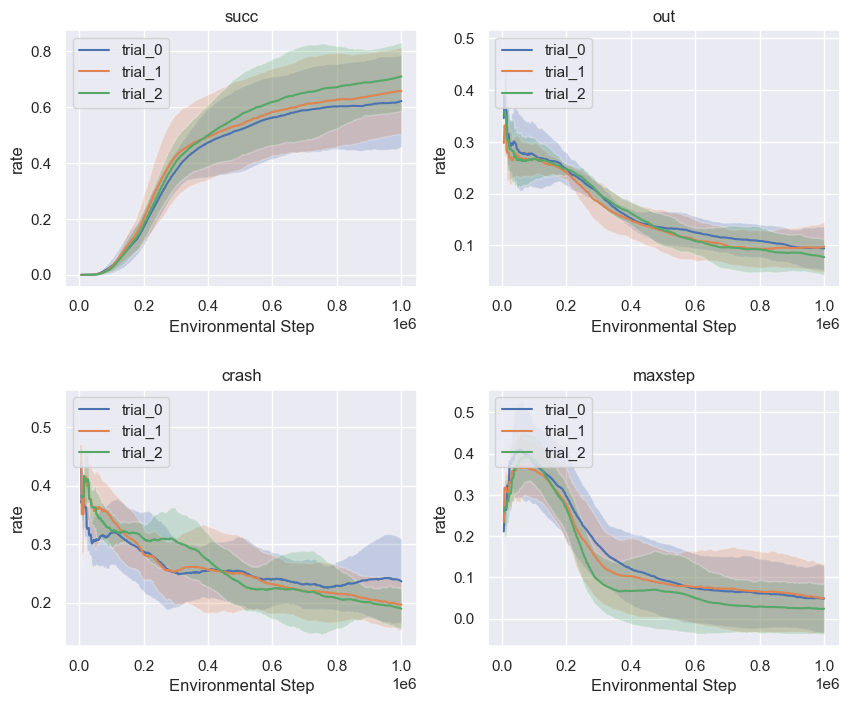

In [4]:
exp_dirs = {
    'trial_0': 'exp_results/IPPO_Intersection_8seeds_30agents', 
    'trial_1': 'exp_results/IPPO_Intersection_8seeds_30agents_repeat', 
    'trial_2': 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2',
    # 'trial_3': 'exp_results/IPPO_Intersection_8seeds_30agents_repeat3_AIBOY'
}
compare_all_metrics(exp_dirs)

### CCPPO

╭────────── generating param spaces ──────────╮
│ input param space:  total  1  params.       │
│ param combinations: total 2=2 combinations: │
│ ------------------- ----------------------- │
│ param label 1:      fuse_mode=concat        │
│ param label 2:      fuse_mode=mf            │
╰─────────────────────────────────────────────╯

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 58.49it/s]


Finished reading 8 seed:  11000, 7000, 9000, 8000, 5000, 10000, 12000, 6000

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 62.75it/s]


Finished reading 8 seed:  9000, 11000, 6000, 7000, 12000, 8000, 10000, 5000

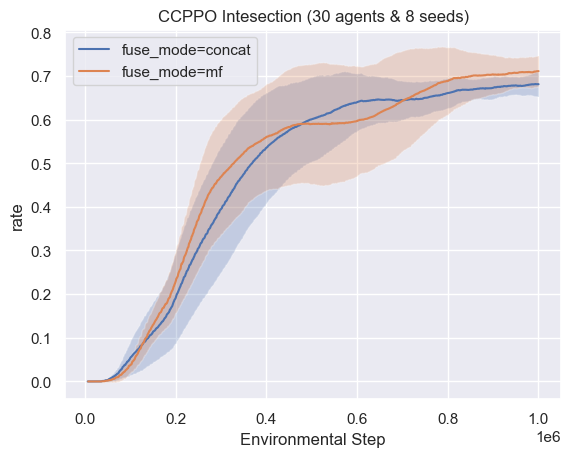

In [10]:
exp_dir = 'exp_results/CCPPO_Intersection_8seeds_30agents'
param_space = {
    'fuse_mode': ['concat', 'mf'],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}

for label, pattern in param_pattern_dict.items():
    plot_one_exp(exp_dir, param_pattern=pattern, col=succ_col, title='CCPPO Intesection (30 agents & 8 seeds)', exp_label=label)

### ARCCPPO

exp param:
- attention 
- random_order

### 不同算法对比

Reading csv in exp_results/IPPO_Intersection_8seeds_30agents...

100%|██████████| 8/8 [00:00<00:00, 31.53it/s]


Finished reading 8 seed:  12000, 8000, 10000, 6000, 9000, 7000, 11000, 5000

╭────────── generating param spaces ──────────╮
│ input param space:  total  1  params.       │
│ param combinations: total 2=2 combinations: │
│ ------------------- ----------------------- │
│ param label 1:      concat                  │
│ param label 2:      mf                      │
╰─────────────────────────────────────────────╯

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 62.00it/s]


Finished reading 8 seed:  11000, 7000, 9000, 8000, 5000, 10000, 12000, 6000

Reading csv in exp_results/CCPPO_Intersection_8seeds_30agents...

100%|██████████| 16/16 [00:00<00:00, 63.42it/s]


Finished reading 8 seed:  9000, 11000, 6000, 7000, 12000, 8000, 10000, 5000

╭─────────── generating param spaces ───────────╮
│ input param space:  total  2  params.         │
│ param combinations: total 1x1=1 combinations: │
│ ------------------- ------------------------- │
│ param label 1:      mlp & id                  │
╰───────────────────────────────────────────────╯

Reading csv in exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro...

100%|██████████| 16/16 [00:00<00:00, 63.24it/s]


Finished reading 8 seed:  5000, 7000, 8000, 11000, 12000, 9000, 10000, 6000

╭───────────── generating param spaces ─────────────╮
│ input param space:  total  4  params.             │
│ param combinations: total 1x1x1x1=1 combinations: │
│ ------------------- ----------------------------- │
│ param label 1:      ^cf & mf & mlp & id           │
╰───────────────────────────────────────────────────╯

Reading csv in exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_cc...

100%|██████████| 128/128 [00:00<00:00, 522.05it/s]


Finished reading 8 seed:  7000, 8000, 12000, 9000, 5000, 6000, 10000, 11000

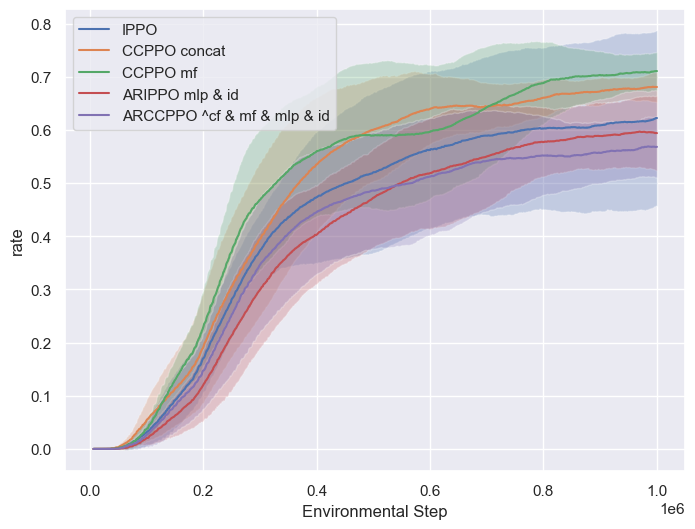

In [16]:
plt.figure(figsize=(8, 6))
# 1. IPPO
ippo_exp_dir = 'exp_results/IPPO_Intersection_8seeds_30agents'
seed_pattern = r'start_seed=(\d*)'
plot_one_exp(ippo_exp_dir, seed_pattern, col=succ_col, exp_label='IPPO')


# 2. CCPPO
ccppo_exp_dir = 'exp_results/CCPPO_Intersection_8seeds_30agents'
param_space = {
    'fuse_mode': [['concat', 'mf'],  ['concat', 'mf']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'CCPPO ' + label 
    plot_one_exp(ccppo_exp_dir, param_pattern=pattern, col=succ_col, exp_label=label)


# 3. ARIPPO
# arccppo_exp_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn'
mlp_no_ro_dir_1 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    'random_order': [['id'], ['False']],
    # 'random_order': [['ro', 'id'], ['True', 'False']],
    # 'random_order': [(''), ['True']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARIPPO ' + label 
    plot_one_exp(mlp_no_ro_dir_1, param_pattern=pattern, col=succ_col, exp_label=label)

# 4. ARCCPPO
exp_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_cc'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'counterfactual': [['cf', '^cf'], ['True', 'False']],
    'counterfactual': [['^cf'], ['False']],
    'fuse_mode': [['mf'], ['mf']],
    # 'fuse_mode': [['concat'], ['concat']],
    # 'fuse_mode': [['concat', 'mf'], ['concat', 'mf']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    'random_order': [['id'], ['False']],
    # 'random_order': [['ro', 'id'], ['True', 'False']],
    # 'random_order': [(''), ['True']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARCCPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=succ_col, exp_label=label)


# pattern = r'use_attention=True(.*?)random_order=True'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (atn & ro)')

# pattern = r'use_attention=True(.*?)random_order=False'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (atn & ^ro')

# pattern = r'use_attention=False(.*?)random_order=True'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (mlp & ro)')

# pattern = r'use_attention=False(.*?)random_order=False'
# plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=succ_col, exp_label='ARCCPPO (mlp & ^ro')

In [17]:
mlp_no_ro_dir = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn/mlp_no_ro_8seeds'
plot_one_exp(arccppo_exp_dir)

NameError: name 'arccppo_exp_dir' is not defined

Reading csv...


100%|██████████| 8/8 [00:00<00:00, 29.13it/s]


Finished reading 8 seed:  5000, 10000, 7000, 6000, 9000, 8000, 12000, 11000
use_attention [['mlp'], ['False']]
random_order [['ro', 'id'], ['True', 'False']]
----
[['use_attention=False'], ['random_order=True', 'random_order=False']]
[['mlp'], ['ro', 'id']]
Reading csv...


100%|██████████| 16/16 [00:00<00:00, 61.04it/s]


Finished reading 8 seed:  8000, 6000, 5000, 12000, 10000, 11000, 7000, 9000
Reading csv...


100%|██████████| 16/16 [00:00<00:00, 65.60it/s]


Finished reading 8 seed:  5000, 7000, 8000, 11000, 12000, 9000, 10000, 6000


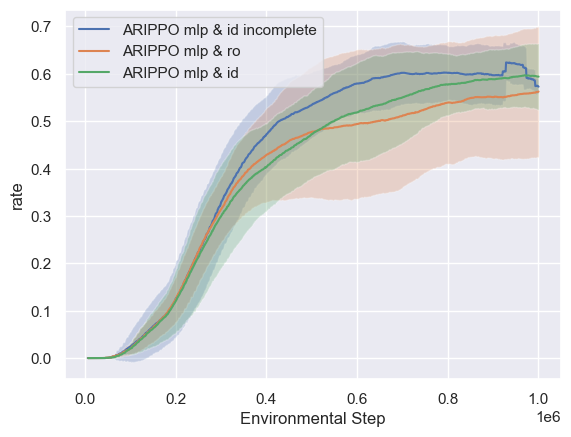

In [153]:
mlp_no_ro_dir_0 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn/mlp_no_ro_8seeds'
plot_one_exp(mlp_no_ro_dir_0, param_pattern=pattern, col=succ_col, exp_label="ARIPPO mlp & id incomplete")


mlp_no_ro_dir_1 = 'exp_results/ARCCPPO_Intersection_8seeds_30agents_atn_mlp_no_ro'
param_space = {
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    'use_attention': [['mlp'], ['False']],
    # 'use_attention': [['atn', 'mlp'], ['True', 'False']],
    # 'random_order': [['ro'], ['True']],
    # 'random_order': [['id'], ['False']],
    'random_order': [['ro', 'id'], ['True', 'False']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
for label, pattern in param_pattern_dict.items():
    label = 'ARIPPO ' + label 
    plot_one_exp(mlp_no_ro_dir_1, param_pattern=pattern, col=succ_col, exp_label=label)



### IPPO 1-agent in Intersection with & without lidar

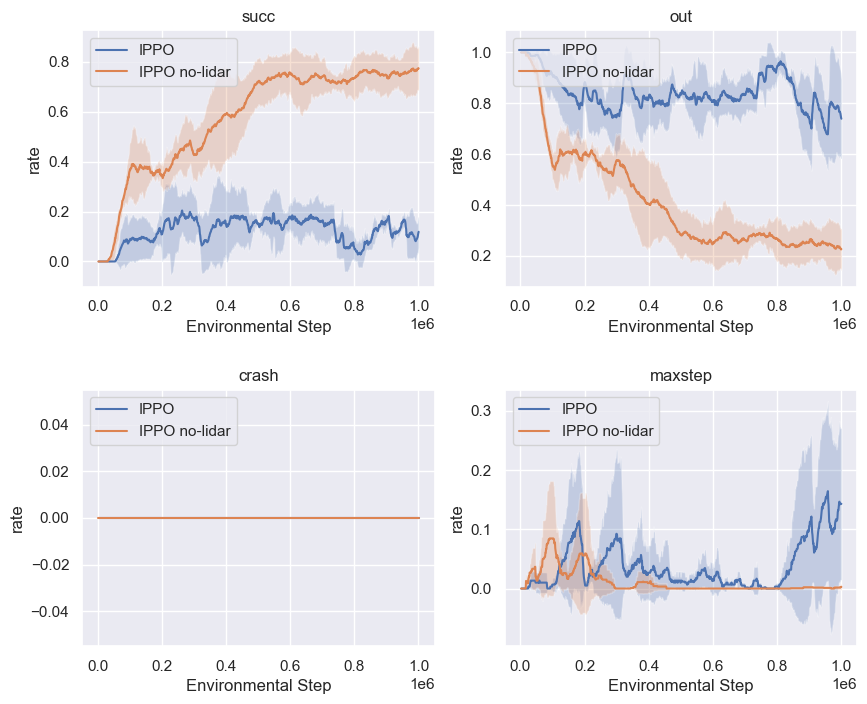

In [4]:
ippo_exp_dir = 'exp_results/IPPO_Intersection_3seeds_1agents_single_agent_test'
ippo_exp_dir_no_lidar = 'exp_results/IPPO_Intersection_3seeds_1agents_single_agent_test_no_lidar'

compare_all_metrics({
    'IPPO': ippo_exp_dir,
    'IPPO no-lidar': ippo_exp_dir_no_lidar
})

Text(0.5, 0.98, '1-agent no lidar 1e6 steps')

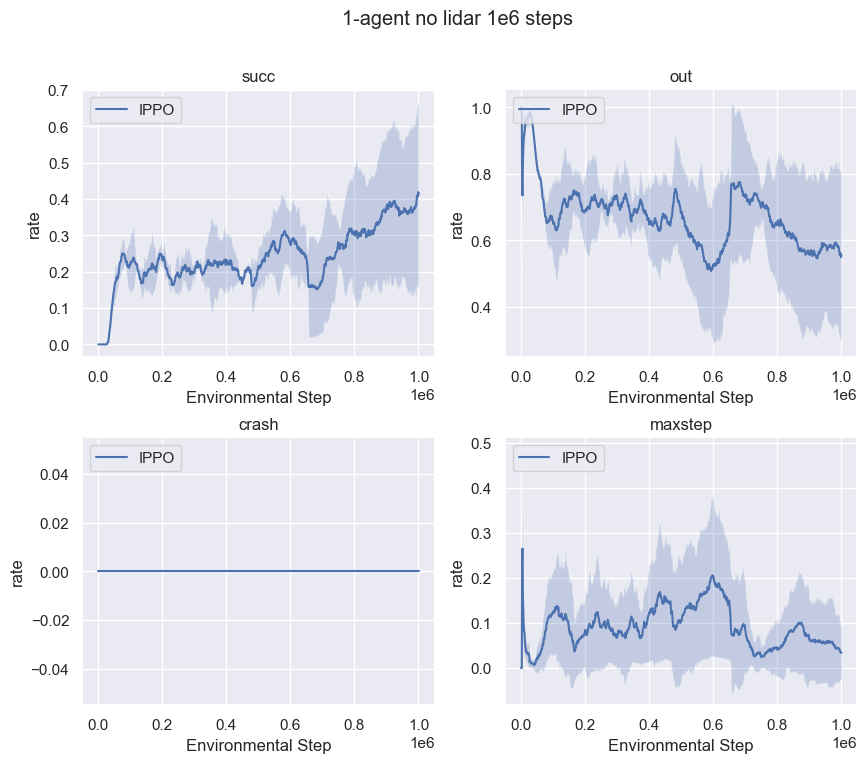

In [2]:
exp_dir = 'exp_results/IPPO_Inter_1agents_(1-agent-no-lidar-1e6)'
compare_all_metrics({
    'IPPO': exp_dir,
})
plt.suptitle('1-agent no lidar 1e6 steps')

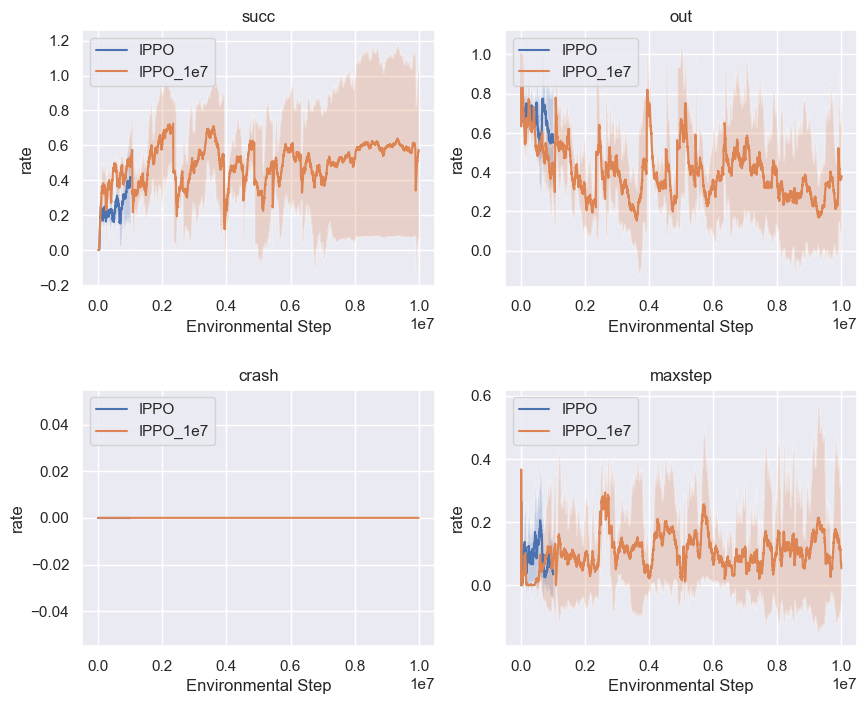

In [10]:
exp_dir_1e7 = 'exp_results/IPPO_Inter_1agents_(1-agent-no-lidar-1e7)'
exp_dir_1e6 = 'exp_results/IPPO_Inter_1agents_(1-agent-no-lidar-1e6)'
compare_all_metrics({
    'IPPO': exp_dir_1e6,
    'IPPO_1e7': exp_dir_1e7,
})

### 4-, 8-, 16-, 30- agents Inter. with & without lidar

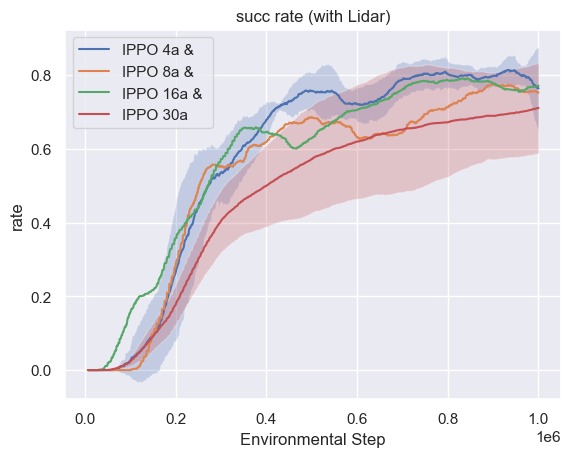

In [32]:
exp_dir = 'exp_results/IPPO_Inter_[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['', ], ['72',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = succ_col
title = 'succ rate (with Lidar)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


pattern = r'start_seed=(\d*)'

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

plot_one_exp(exp_dir_30a, param_pattern=pattern, col=col, title=title, exp_label='IPPO 30a')

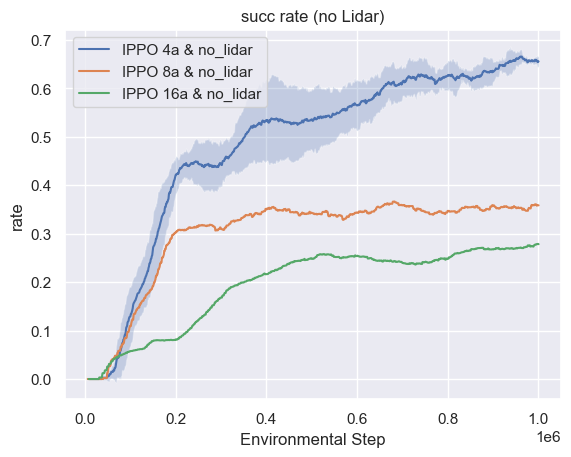

In [33]:
exp_dir = 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['no_lidar'], ['0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = succ_col
title = 'succ rate (no Lidar)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


#### Crash rate:

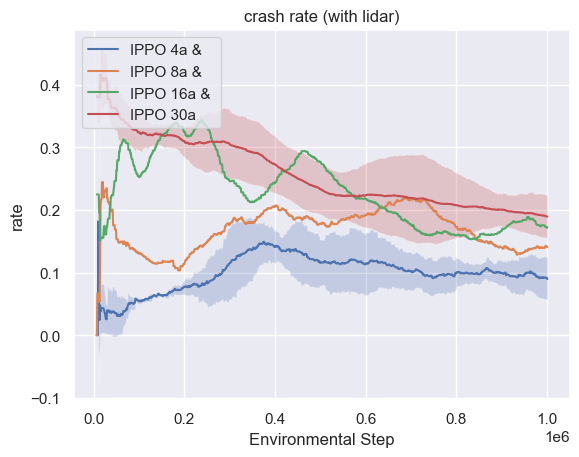

In [35]:
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['', ], ['72',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = crash_col
title = 'crash rate (with lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)

pattern = r'start_seed=(\d*)'

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'
plot_one_exp(exp_dir_30a, param_pattern=pattern, col=col, title=title, exp_label='IPPO 30a')

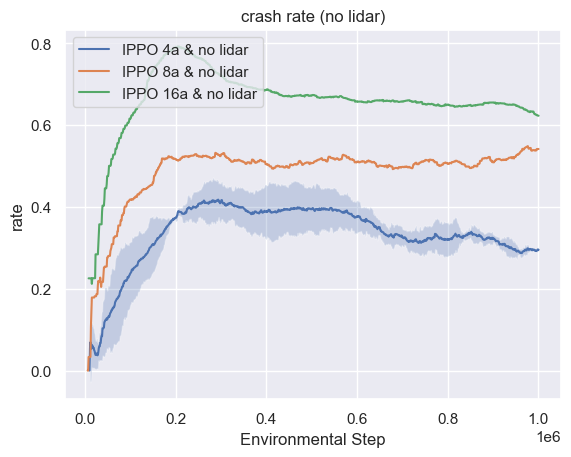

In [36]:
exp_dir = 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['no lidar', ], ['0',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = crash_col
title = 'crash rate (no lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


#### Out rate:

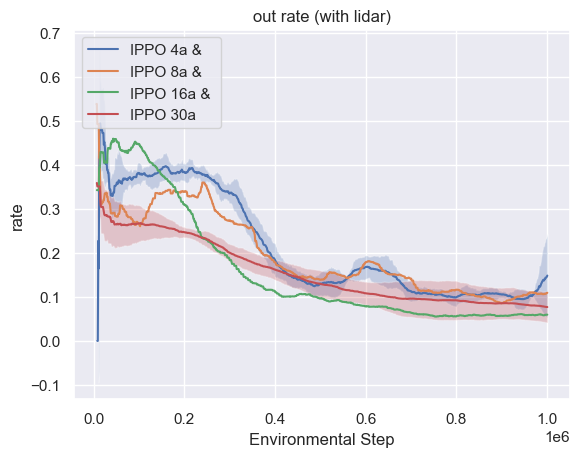

In [37]:
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['', ], ['72',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = out_col
title = 'out rate (with lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)

pattern = r'start_seed=(\d*)'

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'
plot_one_exp(exp_dir_30a, param_pattern=pattern, col=col, title=title, exp_label='IPPO 30a')

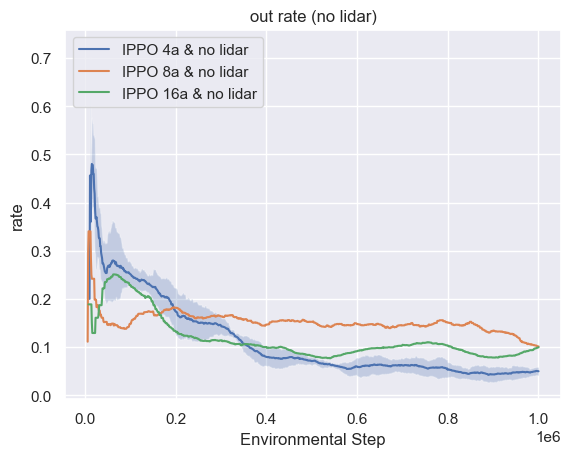

In [38]:
exp_dir = 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['no lidar', ], ['0',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = out_col
title = 'out rate (no lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


#### maxstep rate:

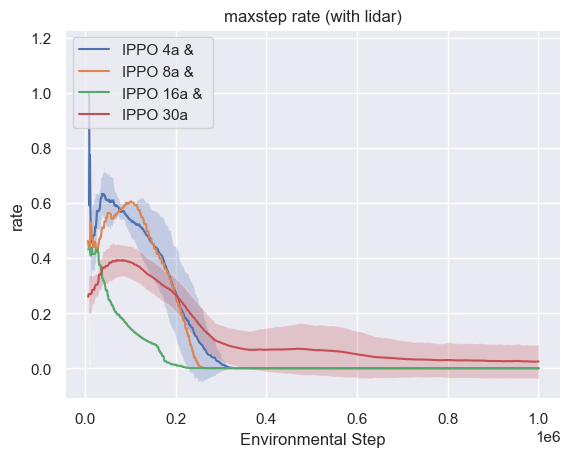

In [39]:
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['', ], ['72',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = maxstep_col
title = 'maxstep rate (with lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)

pattern = r'start_seed=(\d*)'

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'
plot_one_exp(exp_dir_30a, param_pattern=pattern, col=col, title=title, exp_label='IPPO 30a')

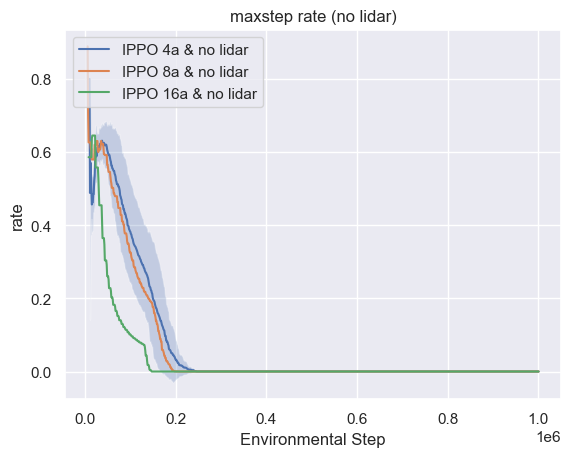

In [40]:
exp_dir = 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['4a', '8a', '16a'], ['4', '8', '16']],
    'num_lasers': [['no lidar', ], ['0',]],
    # 'num_lasers': [['', 'no_lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = maxstep_col
title = 'maxstep rate (no lidar)'
for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


### 16 agents with & no lidar

In [3]:
exp_dir = 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'
param_space = {
    'agents': [['16a'], ['16']],
    'num_lasers': [['', 'no lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = succ_col
title = 'succ rate (with Lidar)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


pattern = r'start_seed=(\d*)'

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

plot_one_exp(exp_dir_30a, param_pattern=pattern, col=col, title=title, exp_label='IPPO 30a')

FileNotFoundError: [Errno 2] No such file or directory: 'exp_results/IPPO_Inter._[4, 8, 16]agents_if_need_lidar'

### Ego-state concatenated with 4 Neighbour-state 
- mlp actor 
- nei state has navi

`nei_distance = 40m`

`num_nei = 4`


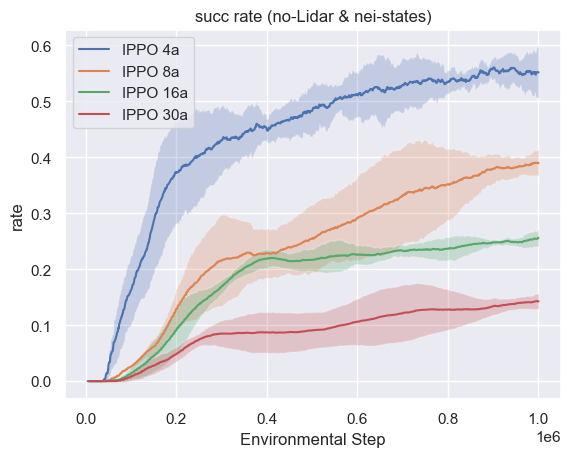

In [4]:
exp_dir = 'exp_results/IPPO_Inter_4-8-16-30agents_no_lidar'
param_space = {
    'agents': [['4a', '8a', '16a', '30a'], ['4', '8', '16', '30']],
    # 'num_lasers': [['', 'no lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = succ_col
title = 'succ rate (no-Lidar & nei-states)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


结论：4个邻近车辆的状态还是太多了，而且其他车辆的状态中还包含它们的下2个导航点信息，增加了网络输入维度，增加了输入噪声

### Ego-state with Fewer Neighbour-state (mlp actor)

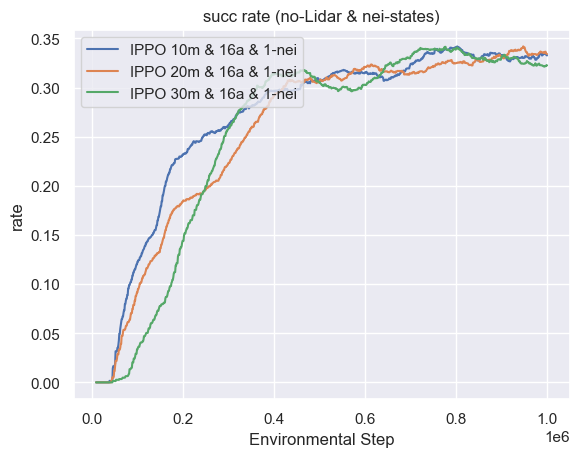

In [10]:
exp_dir = 'exp_results/IPPO_Inter_16agents_16a_nei_state'

param_space = {
    'neighbours_distance': [['10m', '20m', '30m'], ['10', '20', '30']],
    'agents': [['16a'], ['16']],
    'num_neighbours': [['1-nei'], ['1']]
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}

col = succ_col
title = 'succ rate (no-Lidar & nei-states)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label, verbose=False)


### Fewer Neighbours 

with nei-navi

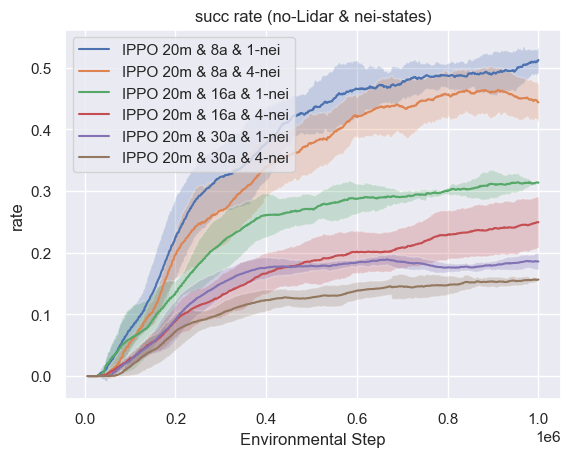

In [11]:
exp_dir = 'exp_results/IPPO_Inter_8-16-30agents_fewer_neighbour'
param_space = {
    'neighbours_distance': [['20m'], ['20']],
    'agents': [['8a', '16a', '30a'], ['8', '16', '30']],
    'num_neighbours': [['1-nei', '4-nei'], ['1', '4']]
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}

col = succ_col
title = 'succ rate (no-Lidar & nei-states)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label, verbose=False)


### Comparing with & without Nei-Navi (mlp actor)

1. `[Ego-State] [Ego-Navi]x2 [Nei-State] [Nei-Navi]x2`

2. `[Ego-State] [Ego-Navi]x2 [Nei-State]`


nei_distance = 40m

num_neighbours = 4

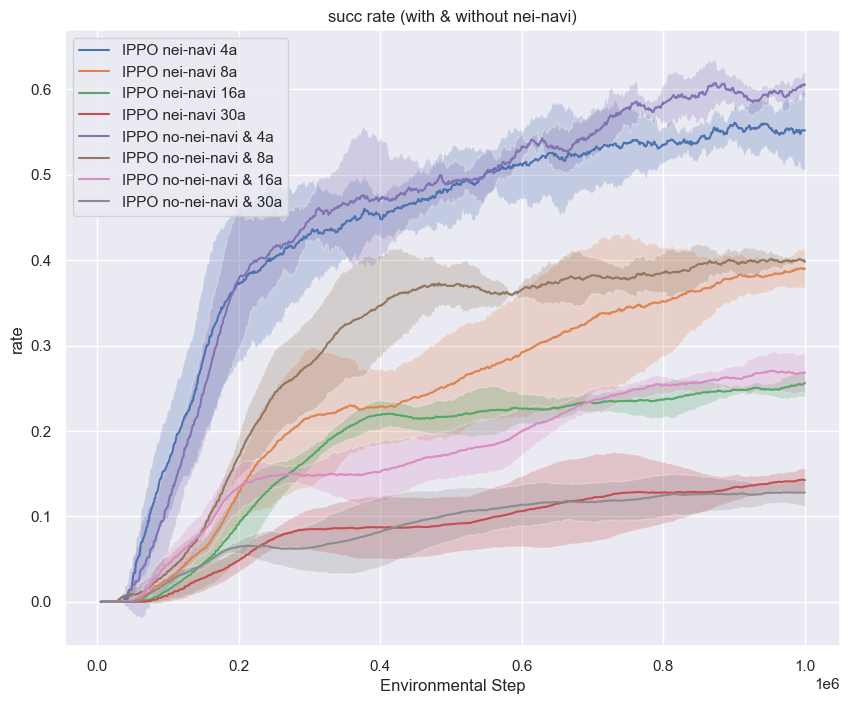

In [5]:
plt.figure(figsize=(10, 8))

exp_dir = 'exp_results/IPPO_Inter_4-8-16-30agents_no_lidar'
param_space = {
    'agents': [['4a', '8a', '16a', '30a'], ['4', '8', '16', '30']],
    # 'num_lasers': [['', 'no lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}
col = succ_col
title = 'succ rate (no-Lidar & nei-states)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO nei-navi ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)


exp_dir = 'exp_results/IPPO_Inter_4-8-16-30agents_no-nei-navi'
param_space = {
    'nei_navi': [['no-nei-navi'], ['False']],
    'agents': [['4a', '8a', '16a', '30a'], ['4', '8', '16', '30']],
}
param_pattern_dict = get_param_patthern(param_space) # {lable -> re pattern}

col = succ_col
title = 'succ rate (with & without nei-navi)'

for label, pattern in param_pattern_dict.items():
    label = 'IPPO ' + label 
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label, verbose=False)


### if lidar needed

╭─────────── generating total 2 param spaces ───────────╮
│ input params:             ['agents', 'num_lasers']    │
│ param combinations:       total 4x2=8 combinations    │
│ ------------------------- --------------------------- │
│ label:                    re pattern:                 │
│ ------------------------- --------------------------- │
│ (label 1) 4a & lidar:     agents=4(.*?)num_lasers=72  │
│ (label 2) 4a & no-lidar:  agents=4(.*?)num_lasers=0   │
│ (label 3) 8a & lidar:     agents=8(.*?)num_lasers=72  │
│ (label 4) 8a & no-lidar:  agents=8(.*?)num_lasers=0   │
│ (label 5) 16a & lidar:    agents=16(.*?)num_lasers=72 │
│ (label 6) 16a & no-lidar: agents=16(.*?)num_lasers=0  │
│ (label 7) 30a & lidar:    agents=30(.*?)num_lasers=72 │
│ (label 8) 30a & no-lidar: agents=30(.*?)num_lasers=0  │
╰───────────────────────────────────────────────────────╯

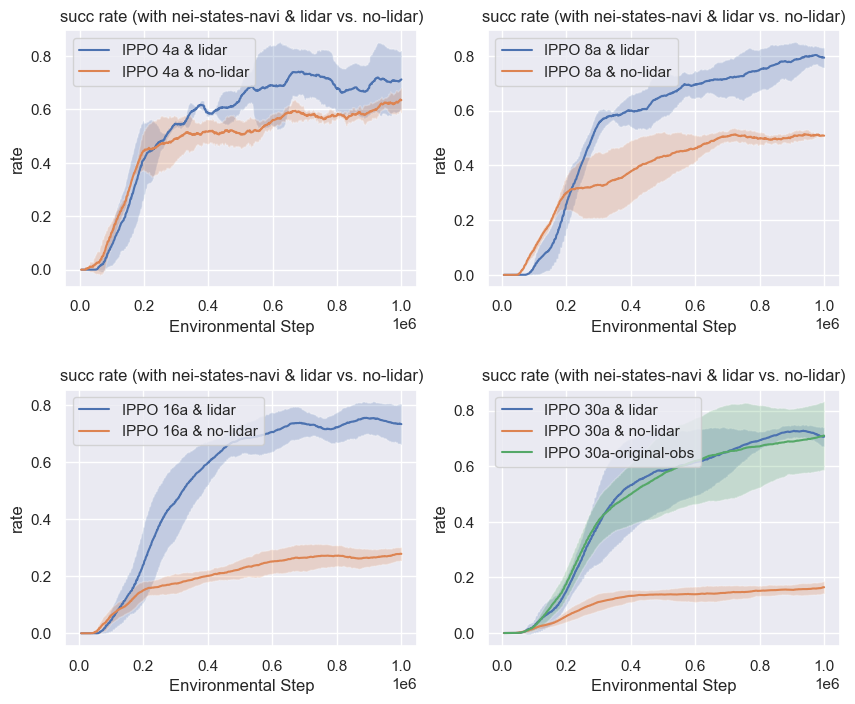

: 

In [19]:
exp_dir = 'exp_results/IPPO_Inter_4-8-16-30agents_1-nei-with-navi&lidar'
param_space = {
    # 'agents': [['30a-add-1-nei-state-navi'], ['30']],
    'agents': [['4a', '8a', '16a', '30a'], ['4', '8', '16', '30']],
    'num_lasers': [['lidar', 'no-lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space, verbose=True) # {lable -> re pattern}

col = succ_col
title = 'succ rate (with nei-states-navi & lidar vs. no-lidar)'

i = 0
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.2)
for label, pattern in param_pattern_dict.items():
    if i % 2 == 0:
        plt.subplot(2,2,i//2+1)
    label = 'IPPO ' + label
    plot_one_exp(exp_dir, param_pattern=pattern, col=col, title=title, exp_label=label)

    i += 1

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

plot_one_exp(exp_dir_30a, col=col, title=title, exp_label='IPPO 30a-original-obs')

### 雷达及邻居数量、邻居信息对不同车密度的影响

╭──────────────────────────────── generating total 4 param spaces ─────────────────────────────────╮
│ input params:                ['nei_navi', 'agents', 'num_neighbours', 'num_lasers']              │
│ param combinations:          total 2x1x1x1=2 combinations                                        │
│ ---------------------------- ------------------------------------------------------------------- │
│ label:                       re pattern:                                                         │
│ ---------------------------- ------------------------------------------------------------------- │
│ (label 1) nei-navi & 30a:    nei_navi=True(.*?)agents=30(.*?)num_neighbours=1(.*?)num_lasers=72  │
│ (label 2) no-nei-navi & 30a: nei_navi=False(.*?)agents=30(.*?)num_neighbours=1(.*?)num_lasers=72 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

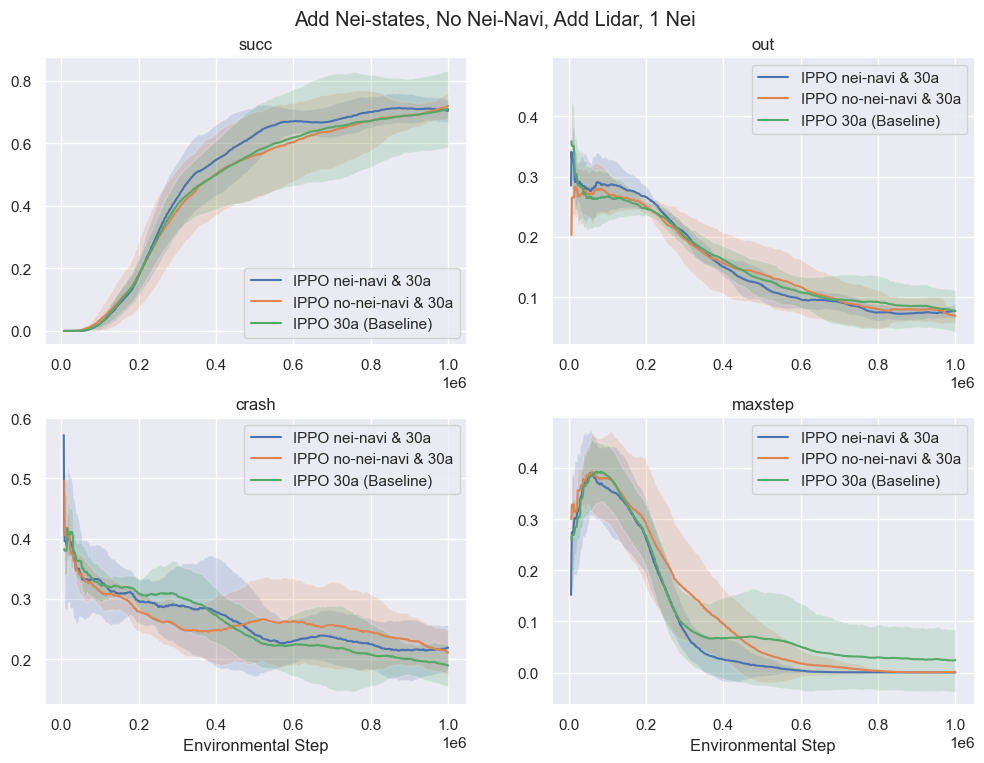

In [17]:
exp_dir = 'exp_results/IPPO_Inter_4-8-16-30agents_1-nei-with-navi&lidar-8seeds[AIBOY]'
param_space = {
    # 'nei_navi': [[''], ['False']],
    'nei_navi': [['nei-navi', 'no-nei-navi'], ['True', 'False']],
    # 'nei_navi': [[''], ['False']],
    # 'agents': [['4a', '8a', '16a', '30a'], ['4', '8', '16', '30']],
    'agents': [['30a'], ['30']],
    # 'num_neighbours': [['1-nei', '4-nei'], ['1', '4']],
    'num_neighbours': [[''], ['1']],
    'num_lasers': [[''], ['72']],
    # 'num_lasers': [['lidar', 'no-lidar'], ['72', '0']],
}
param_pattern_dict = get_param_patthern(param_space, verbose=True) # {lable -> re pattern}

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

add_plot_args = dict(
    IPPO=dict(
        exp_dir=exp_dir_30a,
        pattern=None, 
        label='30a (Baseline)', 
))
# add_plot_args=None

plot_all_metrics_for_params_in_one_exp_dir(exp_dir, "IPPO", param_pattern_dict, 'Add Nei-states, No Nei-Navi, Add Lidar, 1 Nei', add_plot_args)

### Compact Ego- and Nei- states with Lidar

╭─────────── generating total 2 param spaces ───────────╮
│ input params:          ['agents', 'num_neighbours']   │
│ param combinations:    total 2x2=4 combinations       │
│ ---------------------- ------------------------------ │
│ label:                 re pattern:                    │
│ ---------------------- ------------------------------ │
│ (label 1) 8a & 1-nei:  agents=8(.*?)num_neighbours=1  │
│ (label 2) 8a & 4-nei:  agents=8(.*?)num_neighbours=4  │
│ (label 3) 30a & 1-nei: agents=30(.*?)num_neighbours=1 │
│ (label 4) 30a & 4-nei: agents=30(.*?)num_neighbours=4 │
╰───────────────────────────────────────────────────────╯

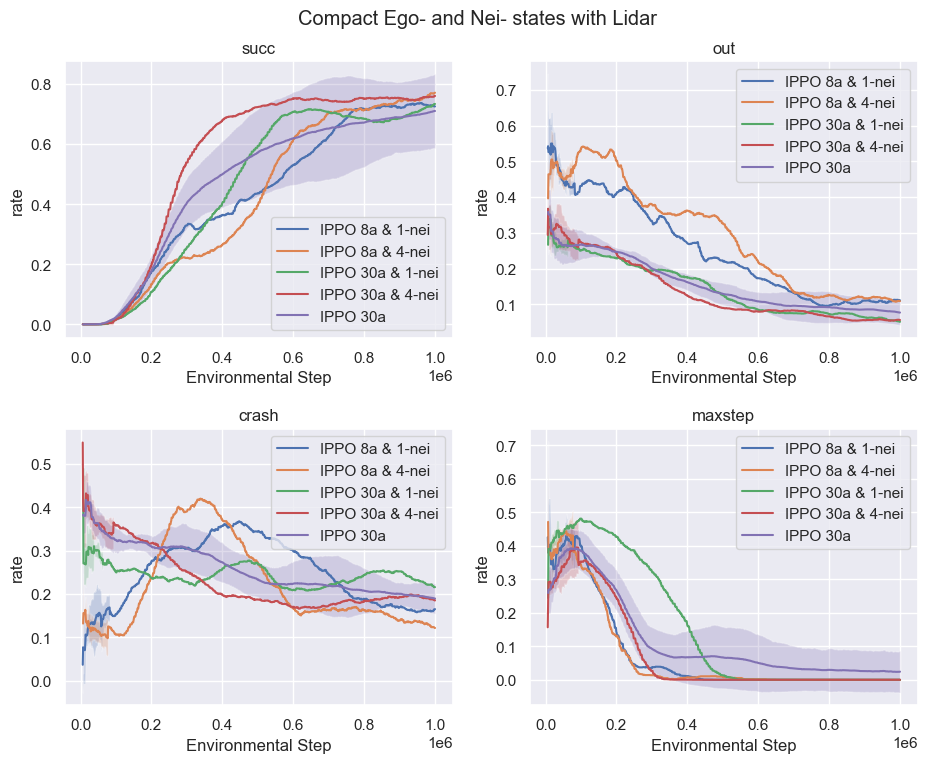

In [2]:
param_space = {
    # 'agents': [['30a-add-1-nei-state-navi'], ['30']],
    'agents': [['8a', '30a'], ['8', '30']],
    'num_neighbours': [['1-nei', '4-nei'], ['1', '4']],
}
param_pattern_dict = get_param_patthern(param_space, verbose=True) # {lable -> re pattern}

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

add_plot_args = dict(
    IPPO=dict(
        exp_dir=exp_dir_30a,
        pattern=None, 
        label='30a', 
))

plot_all_metrics_for_params_in_one_exp_dir(exp_dir, "IPPO", param_pattern_dict, 'Compact Ego- and Nei- states with Lidar', add_plot_args)

### add heading

╭─────────── generating total 2 param spaces ───────────╮
│ input params:          ['agents', 'num_neighbours']   │
│ param combinations:    total 3x2=6 combinations       │
│ ---------------------- ------------------------------ │
│ label:                 re pattern:                    │
│ ---------------------- ------------------------------ │
│ (label 1) 8a & 1-nei:  agents=8(.*?)num_neighbours=1  │
│ (label 2) 8a & 4-nei:  agents=8(.*?)num_neighbours=4  │
│ (label 3) 16a & 1-nei: agents=16(.*?)num_neighbours=1 │
│ (label 4) 16a & 4-nei: agents=16(.*?)num_neighbours=4 │
│ (label 5) 30a & 1-nei: agents=30(.*?)num_neighbours=1 │
│ (label 6) 30a & 4-nei: agents=30(.*?)num_neighbours=4 │
╰───────────────────────────────────────────────────────╯

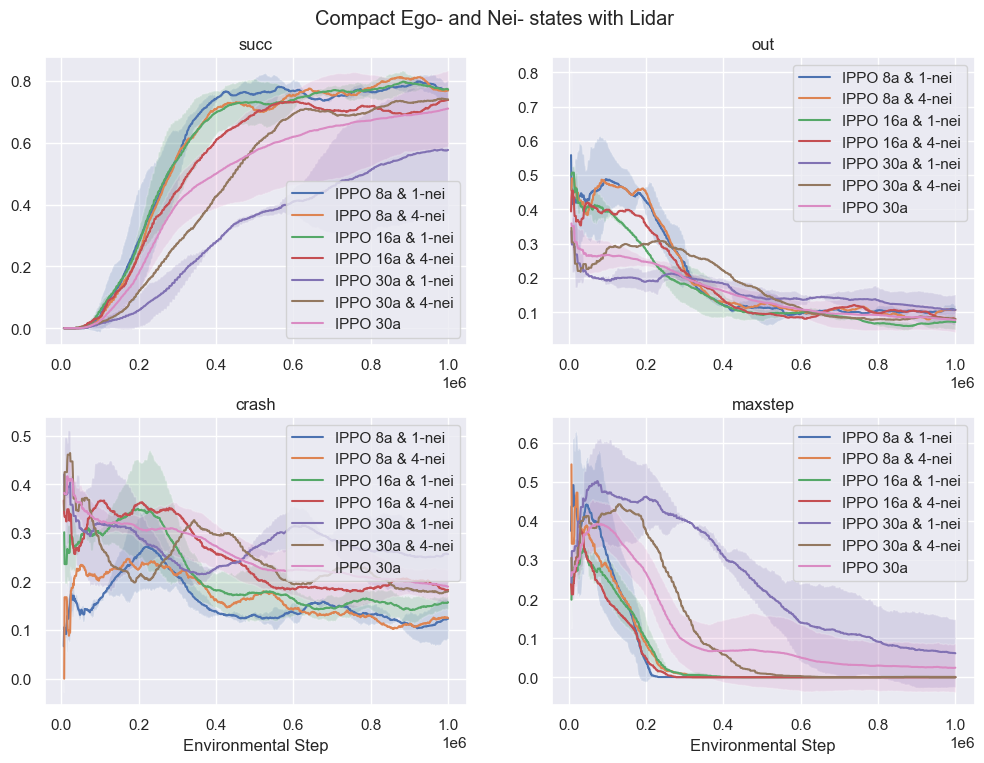

: 

In [19]:
exp_dir = 'exp_results/IPPO_Inter_8-16-30agents_(compact-state)'
param_space = {
    # 'agents': [['30a-add-1-nei-state-navi'], ['30']],
    'agents': [['8a', '16a', '30a'], ['8', '16', '30']],
    'num_neighbours': [['1-nei', '4-nei'], ['1', '4']],
}
param_pattern_dict = get_param_patthern(param_space, verbose=True) # {lable -> re pattern}

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'

add_plot_args = dict(
    IPPO=dict(
        exp_dir=exp_dir_30a,
        pattern=None, 
        label='30a', 
))

plot_all_metrics_for_params_in_one_exp_dir(exp_dir, "IPPO", param_pattern_dict, 'Compact Ego- and Nei- states with Lidar', add_plot_args)

╭─────────── generating total 2 param spaces ───────────╮
│ input params:          ['agents', 'num_neighbours']   │
│ param combinations:    total 2x2=4 combinations       │
│ ---------------------- ------------------------------ │
│ label:                 re pattern:                    │
│ ---------------------- ------------------------------ │
│ (label 1) 8a & 1-nei:  agents=8(.*?)num_neighbours=1  │
│ (label 2) 8a & 4-nei:  agents=8(.*?)num_neighbours=4  │
│ (label 3) 30a & 1-nei: agents=30(.*?)num_neighbours=1 │
│ (label 4) 30a & 4-nei: agents=30(.*?)num_neighbours=4 │
╰───────────────────────────────────────────────────────╯

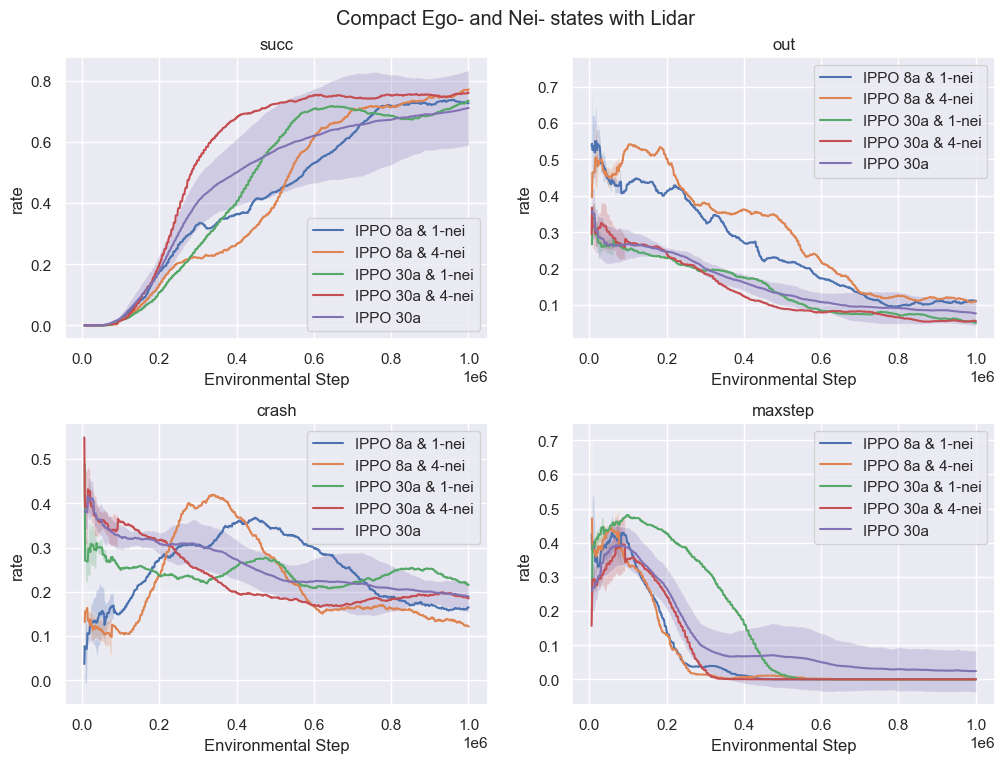

In [3]:
def plot_all_metrics_for_params_in_one_exp_dir(
    exp_dir: str, 
    algo_name: str,
    param_pattern_dict: Dict[str, str],
    title: str = '',
    additional_plot_args: dict = None,
    # a_exp_dir: str = None,
):
    ''' 绘制一个目录中不同超参设置下的所有实验的所有指标, 绘制一个2X2的图形
        用于同一个目录下不同超参在各个指标下的对比
    Args:
        kwargs: additional plot args
            {
                'exp_name': {
                    'exp_dir', 'pattern', 'label', ...
                } x N
            }
    '''
    fig = plt.figure(figsize=(12, 8))
    fig.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2)
    i = 1
    for metric, col in all_metrics.items():
        plt.subplot(2, 2, i)
        for label, pattern in param_pattern_dict.items():
            plot_one_exp(exp_dir=exp_dir, param_pattern=pattern, col=col, title=metric, exp_label=algo_name+' '+label)
        if additional_plot_args:
            for exp_name, args in additional_plot_args.items():
                a_exp_dir = args['exp_dir']
                a_pattern = args.get('pattern', None)
                a_label = args.get('label', '')
                plot_one_exp(exp_dir=a_exp_dir, param_pattern=a_pattern, col=col, title=metric, exp_label=exp_name+' '+a_label)

        i += 1

    plt.suptitle(title)
    


exp_dir = 'exp_results/IPPO_Inter_8-30agents_(compact-state)'
param_space = {
    # 'agents': [['30a-add-1-nei-state-navi'], ['30']],
    'agents': [['8a', '30a'], ['8', '30']],
    'num_neighbours': [['1-nei', '4-nei'], ['1', '4']],
}
param_pattern_dict = get_param_patthern(param_space, verbose=True) # {lable -> re pattern}

exp_dir_30a = 'exp_results/IPPO_Intersection_8seeds_30agents_repeat2'
add_plot_args = dict(
    IPPO=dict(
        exp_dir=exp_dir_30a,
        pattern=None, 
        label='30a', 
))

plot_all_metrics_for_params_in_one_exp_dir(exp_dir, 'IPPO', param_pattern_dict, 'Compact Ego- and Nei- states with Lidar', add_plot_args)
